In [1]:
#Algorithmes pour séparer les couteurs en catégories et identifier les pics de performance

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as pltlines
import math
import statsmodels.tsa.filters.hp_filter as stat

import seaborn as sns
from datetime import datetime
import time
import scipy

In [3]:
data=pd.read_csv("10_km_Riorges.csv")

In [4]:
data

,Athlète,Ligue,Performance,Naissance,Catégorie,time_delta,time_gap,duration,Nom,Prénom
0,LORTON Guillaume,ARA,N4,1989,SEM,0 days 00:30:58,0 days 00:00:00,1858.0,LORTON,Guillaume
1,BETRON Adrien,ARA,IR1,1989,SEM,0 days 00:31:30,0 days 00:00:32,1890.0,BETRON,Adrien
2,MOULIN Loic,ARA,IR2,1992,SEM,0 days 00:32:01,0 days 00:01:03,1921.0,MOULIN,Loic
3,DEBROUCKER Guillaume,ARA,IR2,1982,M1M,0 days 00:32:15,0 days 00:01:17,1935.0,DEBROUCKER,Guillaume
4,KEMEI Charles,ARA,IR2,1984,M0M,0 days 00:32:40,0 days 00:01:42,1960.0,KEMEI,Charles
...,...,...,...,...,...,...,...,...,...,...
245,BARTASSOT Jean,0,D8,1980,M1M,0 days 01:05:58,0 days 00:35:00,3958.0,BARTASSOT,Jean
246,SURGET Laurent,0,D8,1965,M4M,0 days 01:06:37,0 days 00:35:39,3997.0,SURGET,Laurent
247,GENEVOIS Magali,0,D8,1986,M0F,0 days 01:07:18,0 days 00:36:20,4038.0,GENEVOIS,Magali
248,CAVELIER Clementine,0,D8,1990,SEF,0 days 01:07:20,0 days 00:36:22,4040.0,CAVELIER,Clementine


In [5]:
dur=data['duration']


In [7]:
def dens(dur,**kwargs):
    #calcule une densité d'un itérable
    #**kwargs vont etre redonnés à la fonction maptplotlib.pyplot.hist 
    #l'argument density est forcé à : True
    #input :  dur, itérable (liste, série...) de dimension 1
    #output : dens : array nupmy de dimension 2
    
    kwargs['density'] = True
    h=plt.hist(dur, **kwargs)
    xhist = []
    plt.close()
    for i in range (len(h[1])-1):
        x = (h[1][i+1]+h[1][i])/2
        xhist.append(x)
    

    densite=np.zeros((2, len(xhist)))
    densite[0,:] = xhist
    densite[1,:] = h[0]
    return densite


In [8]:
densite = dens(data['duration'], bins=12)
densite


array([[1.95745833e+03, 2.15637500e+03, 2.35529167e+03, 2.55420833e+03,
        2.75312500e+03, 2.95204167e+03, 3.15095833e+03, 3.34987500e+03,
        3.54879167e+03, 3.74770833e+03, 3.94662500e+03, 4.14554167e+03],
       [1.60871387e-04, 6.03267700e-04, 7.03812317e-04, 7.44030163e-04,
        6.43485547e-04, 5.02723083e-04, 5.22832007e-04, 5.42940930e-04,
        4.22287390e-04, 4.02178467e-05, 1.20653540e-04, 2.01089233e-05]])

In [9]:
def separate(densite):
    #prend en argument un array numpy de valeurs et sépare le signal en "tendance" et "bruit" avec un lambda de 0.1
    #input :  densite : array numpy de dimension 2, taille (k,n),
    #output : array nupmy de dimension 2, taille (k+1,n)
  
    b,t = stat.hpfilter(densite[-1,:],lamb = 0.1)
    result = np.zeros((len(densite)+1,len(densite[0])))
    result[0:len(densite),:]= densite
    result[-2]= b
    result[-1]=t
    return result

brten=separate(densite)
brten

array([[ 1.95745833e+03,  2.15637500e+03,  2.35529167e+03,
         2.55420833e+03,  2.75312500e+03,  2.95204167e+03,
         3.15095833e+03,  3.34987500e+03,  3.54879167e+03,
         3.74770833e+03,  3.94662500e+03,  4.14554167e+03],
       [-2.37651182e-05,  3.50334081e-05, -1.03685806e-05,
         8.87094354e-06,  3.31919486e-06, -2.41857378e-05,
        -3.45309733e-06,  1.56046306e-05,  3.77148571e-05,
        -6.83323890e-05,  3.36791307e-05, -4.11724179e-06],
       [ 1.84636505e-04,  5.68234292e-04,  7.14180897e-04,
         7.35159220e-04,  6.40166352e-04,  5.26908821e-04,
         5.26285104e-04,  5.27336299e-04,  3.84572533e-04,
         1.08550236e-04,  8.69744093e-05,  2.42261651e-05]])

In [10]:
densite[0].shape


(12,)

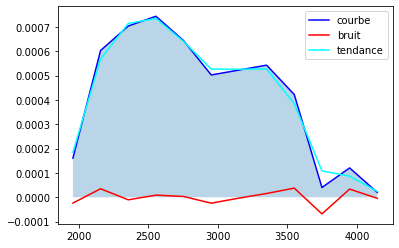

In [11]:
plt.plot(brten[0],densite[1], color = "blue", label = 'courbe')
plt.plot(brten[0],brten[1], color = "red", label = 'bruit')
plt.plot(brten[0],brten[2], color = "cyan", label = 'tendance')
plt.fill_between(brten[0],densite[1], alpha=0.3)

plt.legend()
plt.show()


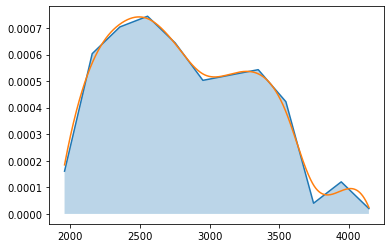

In [13]:
proxlin = scipy.interpolate.interp1d(densite[0],densite[1], kind = 'linear')
poly = scipy.interpolate.splrep(densite[0],brten[2]) #fabrication du polynôme interpolateur sur la tendance seulement, le bruit a tendance à faire des oscillations
x=np.linspace(densite[0,0],densite[0,-1], int(1e6))
ylin = proxlin(x)
ycub=scipy.interpolate.splev(x,poly, der=0)

plt.fill_between(densite[0],densite[1], alpha=0.3)

plt.plot(densite[0],densite[1],x,ycub)






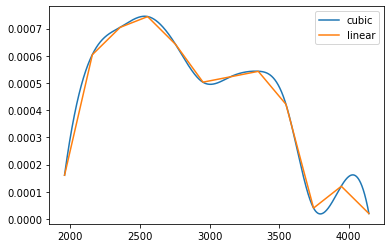

In [29]:
def lissage (x, sep=False, kind = 'cubic'): #sans **kwargs pour simplifier son utilisation
    #prend en argument un ensemble de points à interpoler stockés dans un array numpy et retourne la fonction d'interpolation cubique
    # Input : x : array numpy de dimension 2, taille(2,n) avec les abscisses des points à interpoler dans x[0] et leurs ordonnées dans x[1]
    #       sep : booléen. True si le signal doit être filtré par un HP filter
    if sep ==True :
        t=separate(x)[2]
    else :
        t=x[1]
    if kind == 'cubic':
        poly = scipy.interpolate.splrep(x[0],t)
        def f (X):
            return(scipy.interpolate.splev(X,poly, der=0))
        
    else :
        interp=(scipy.interpolate.interp1d(x[0],t, kind='linear'))
        def f (X):
            return interp(X)
            
    return f


f=lissage(densite)
g=lissage(densite, kind = 'linear')
plt.plot(x,f(x), label = "cubic")
plt.plot(x,g(x), label = "linear")
plt.legend()
plt.show()

    

In [26]:
#test de fonctionnement 1:
print(scipy.integrate.quad(lambda x : lissage(densite,sep=False, kind = 'linear')(x),densite[0][0], densite[0][-1]))
# (0.9819998389448525, 1.329241666736536e-07)
#l'interpolation linéaire fait lever un warning lors de l'intégration car elle est affine par morceaux.

#test de fonctionnement2:
print(scipy.integrate.quad(lambda x: lissage(densite, sep = True)(x),densite[0][0], densite[0][-1]))
#(0.9925168327790789, 6.901821989123772e-09)

C:\Users\tayoy\AppData\Local\Temp/ipykernel_22304/863205358.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  print(scipy.integrate.quad(lambda x : lissage(densite,sep=False, kind = 'linear')(x),densite[0][0], densite[0][-1]))


(0.9819998389448525, 1.329241666736536e-07)
(0.9925168327790789, 6.901821989123772e-09)


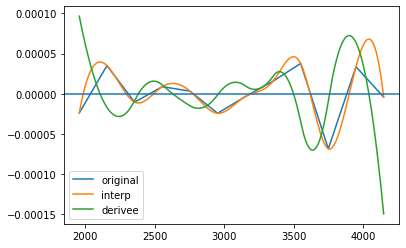

In [92]:

x= np.linspace(brten[0,0],brten[0,-1], int(1e5))
poly = scipy.interpolate.splrep(brten[0],brten[1])
def f0(x):
    return scipy.interpolate.splev(x, poly, der = 0)
def f1(x):
    return 1e2*scipy.interpolate.splev(x, poly, der = 1)
def f2(x):
    return 1e2*scipy.interpolate.splev(x, poly, der = 2)
h0 = f0(x)
h1 = f1(x)
plt.plot(brten[0], brten[1], label = 'original')
plt.plot(x,h0, label = 'interp')
plt.plot(x,h1, label = 'derivee')
plt.legend()
plt.axhline(0)


racines : [2106.52601419 2106.52604047 2381.76627902 2629.54163945 2629.54163945
 2957.56550944 3219.2365012  2957.56221805 3497.5151396  3756.00168176
 3756.00189644 4039.29051428]
floor : [2629.0, 4039.0, 3497.0, 3756.0, 2381.0, 2957.0, 3219.0, 2106.0]
sorted : [2106.0, 2381.0, 2629.0, 2957.0, 3219.0, 3497.0, 3756.0, 4039.0]
Comparaison : 2156.375 , 2106.0
Comparaison : 2554.208333333333 , 2629.0
Comparaison : 3548.7916666666665 , 3497.0
Comparaison : 3946.625 , 4039.0
[2106.0, 2381.0, 2629.0, 2957.0, 3219.0, 3497.0, 3756.0, 4039.0]
[2106.0, 2629.0, 3497.0, 4039.0]


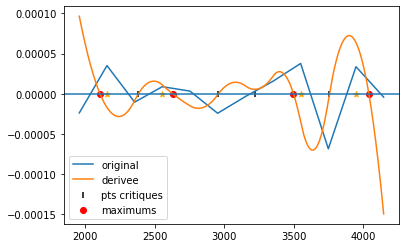

In [150]:
guess = densite[0]

roots = scipy.optimize.root(f1, guess).x
print(f"racines : {roots}")
roots = list(set(np.floor(roots))) #floor permet de se limiter aux valeurs entières et eliminer les doublons dûs à scipy.optimize.root
print(f"floor : {roots}")
roots=sorted(roots)
print((f"sorted : {roots}"))

tops = []
for i in range (len(roots)):
    if f2(roots[i])<0:
        tops.append(roots[i])
        
realTops = []
for i in tops:
    ind=np.argmin(abs(densite[0]-i))
    print(f'Comparaison : {densite[0,ind]} , {i}')
    realTops=realTops+[densite[0, ind]]
    

plt.plot(brten[0], brten[1], label = 'original')
#plt.plot(x,h0, label = 'interp')
plt.plot(x,h1, label = 'derivee')
plt.scatter(roots, [0]*len(roots), marker = '|', color = 'black', label = 'pts critiques')
plt.scatter(tops, [0]*len(tops), marker = 'o', color = 'red', label = 'maximums')
plt.scatter(realTops, [0]*len(realTops),marker = '*', color = 'orange')
plt.legend()
plt.axhline(0)
print(roots)
print(tops)


